# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [121]:
import time

import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import scipy.spatial as ss
import sklearn.mixture as mx
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%matplotlib inline

Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [122]:
data_df = pd.read_csv("../hw2/files/hw2_out.csv", sep="\t", header=0, index_col="twitter_id")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы.

In [123]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("b.kopin") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [125]:
from scipy.misc import logsumexp

EPS = np.finfo(float).eps


def covar_mstep_diag(gmm, X, responsibilities, weighted_X_sum, norm,
                      min_covar):
    """Performing the covariance M step for diagonal cases"""
    avg_X2 = np.dot(responsibilities.T, X * X) * norm
    avg_means2 = gmm.means_ ** 2
    avg_X_means = gmm.means_ * weighted_X_sum * norm
    return avg_X2 - 2 * avg_X_means + avg_means2 + min_covar


def log_multivariate_normal_density(X, means, covars):
    """
    Returns
    -------
    lpr : array_like, shape (n_samples, n_components)
        Array containing the log probabilities of each data point in
        X under each of the n_components multivariate Gaussian distributions.
    """
    n_samples, n_dim = X.shape
    lpr = -0.5 * (n_dim * np.log(2 * np.pi) + np.sum(np.log(covars), 1)
                  + np.sum((means ** 2) / covars, 1)
                  - 2 * np.dot(X, (means / covars).T)
                  + np.dot(X ** 2, (1.0 / covars).T))
    return lpr


class Clustering:
    """
    Attributes
    ----------
    weights_ : array, shape (`n_components`,)
        This attribute stores the mixing weights for each mixture component.
    means_ : array, shape (`n_components`, `n_features`)
        Mean parameters for each mixture component.
    covars_ : array, shape (`n_components`, `n_features`)
        Diag Covariance parameters for each mixture component. 
    converged_ : bool
        True when convergence was reached in fit(), False otherwise.
    """
    
    def __init__(self, n_components, tol=1e-3,
                 n_init=10, n_iter=100, min_covar=1e-3, **kwargs):
        self.n_components = n_components
        self.tol = tol
        self.n_init = n_init
        self.n_iter = n_iter
        self.min_covar = min_covar
        
    def score_samples(self, X):
        """
        Returns
        -------
        logprob : array_like, shape (n_samples,)
            Log probabilities of each data point in X.
        responsibilities : array_like, shape (n_samples, n_components)
            Posterior probabilities of each mixture component for each
            observation
        """
        lpr = (log_multivariate_normal_density(X, self.means_, self.covars_)
               + np.log(self.weights_))
        logprob = logsumexp(lpr, axis=1)
        responsibilities = np.exp(lpr - logprob[:, np.newaxis])
        return logprob, responsibilities
        
    def fit(self, X, y=None):
        """
        Parameters
        ----------
        X : array, shape (n_objects, n_features)
            List of n_features-dimensional data points.  Each row
            corresponds to a single data point.
        """
        # initialization step
        max_log_prob = -np.infty
        
        # shape (`n_components`, `n_features`)
        self.weights_ = np.tile(1.0 / self.n_components,
                                self.n_components)

        # shape (`n_components`,)
        self.means_ = sc.KMeans(n_clusters=self.n_components).fit(X).cluster_centers_

        # shape (`n_components`, `n_features`)
        cv = np.cov(X.T) + self.min_covar * np.eye(X.shape[1])
        self.covars_ = np.tile(np.diag(cv), (self.n_components, 1))
        
        # EM algorithms
        current_log_likelihood = None
        # reset self.converged_ to False
        self.converged_ = False

        for i in range(self.n_iter):
            prev_log_likelihood = current_log_likelihood
            # Expectation step
            log_likelihoods, responsibilities = self.score_samples(X)
            current_log_likelihood = log_likelihoods.mean()

            # Check for convergence.
            if prev_log_likelihood is not None:
                change = abs(current_log_likelihood - prev_log_likelihood)
                if change < self.tol:
                    self.converged_ = True
                    break

            # Maximization step
            self._do_mstep(X, responsibilities, self.min_covar)
        
        return self
    
    def _do_mstep(self, X, responsibilities, min_covar=0):
        """
        Returns
        ----------
        weights : array, shape (`n_components`,)
            Updated GMM weights.
        """
        weights = responsibilities.sum(axis=0)
        weighted_X_sum = np.dot(responsibilities.T, X)
        inverse_weights = 1.0 / (weights[:, np.newaxis] + 10 * EPS)

        self.weights_ = (weights / (weights.sum() + 10 * EPS) + EPS)
        self.means_ = weighted_X_sum * inverse_weights
        self.covars_ = covar_mstep_diag(
            self, X, responsibilities, weighted_X_sum, inverse_weights,
            min_covar)
        return weights
    
    def predict(self, X):
        """
        Predict label for data.
        Returns
        -------
            C : array, shape = (n_samples,)
        """
        _, responsibilities = self.score_samples(X)
        return responsibilities.argmax(axis=1)
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)
    
        # model = mx.GMM(self.n_components).fit(x, y)
        # return model.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

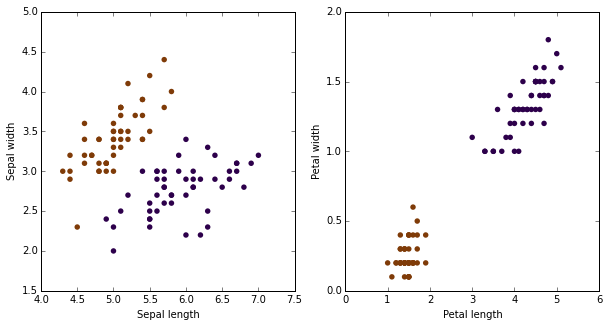

In [126]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [127]:
pred_iris = Clustering(2).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [128]:
def quality(x, y):
    """
    Inertia quality criteria.
    Used
    ----------
    means : array, shape (`n_classes`, `m_features`)
        Clusters centroids.
    """
    y_set = set(y)
    means = [np.mean(np.array(x[np.nonzero(y==k)]).T, axis=1) for k in y_set]
    means = np.array(means)
    squared_norm = [np.linalg.norm(x[np.nonzero(y==k)] - means[i], axis=1)**2 for i, k in enumerate(y_set)]
    sum_over_class = [sum(squared_norm[i]) for i, _ in enumerate(y_set)]
    
    return sum(sum_over_class)


Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

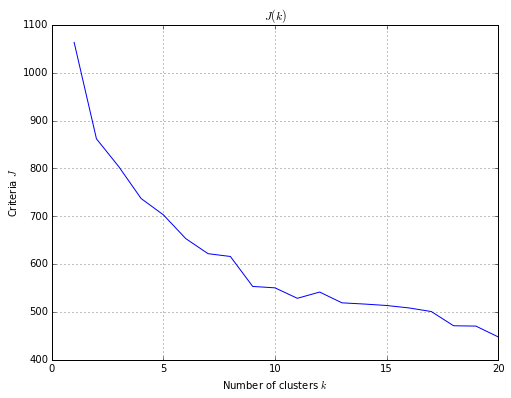

In [129]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k)
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [130]:
k = 5
cls = Clustering(7)
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2993
[t-SNE] Computed conditional probabilities for sample 2000 / 2993
[t-SNE] Computed conditional probabilities for sample 2993 / 2993
[t-SNE] Mean sigma: 0.135861
[t-SNE] Error after 83 iterations with early exaggeration: 19.832993
[t-SNE] Error after 321 iterations: 2.122482


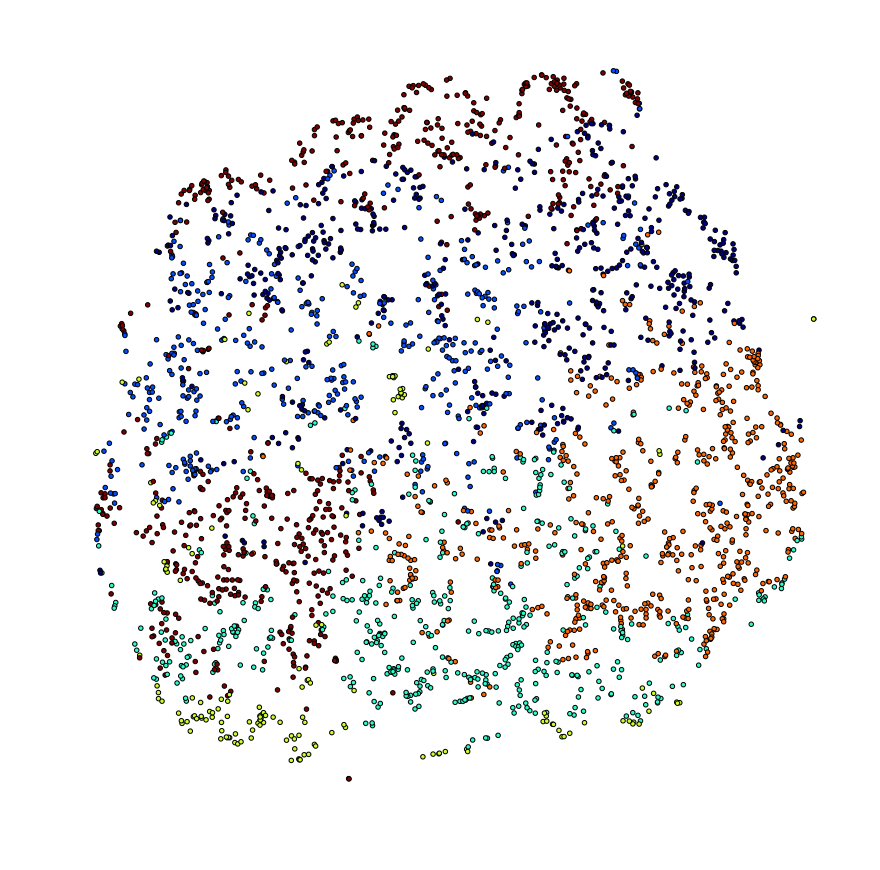

In [131]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

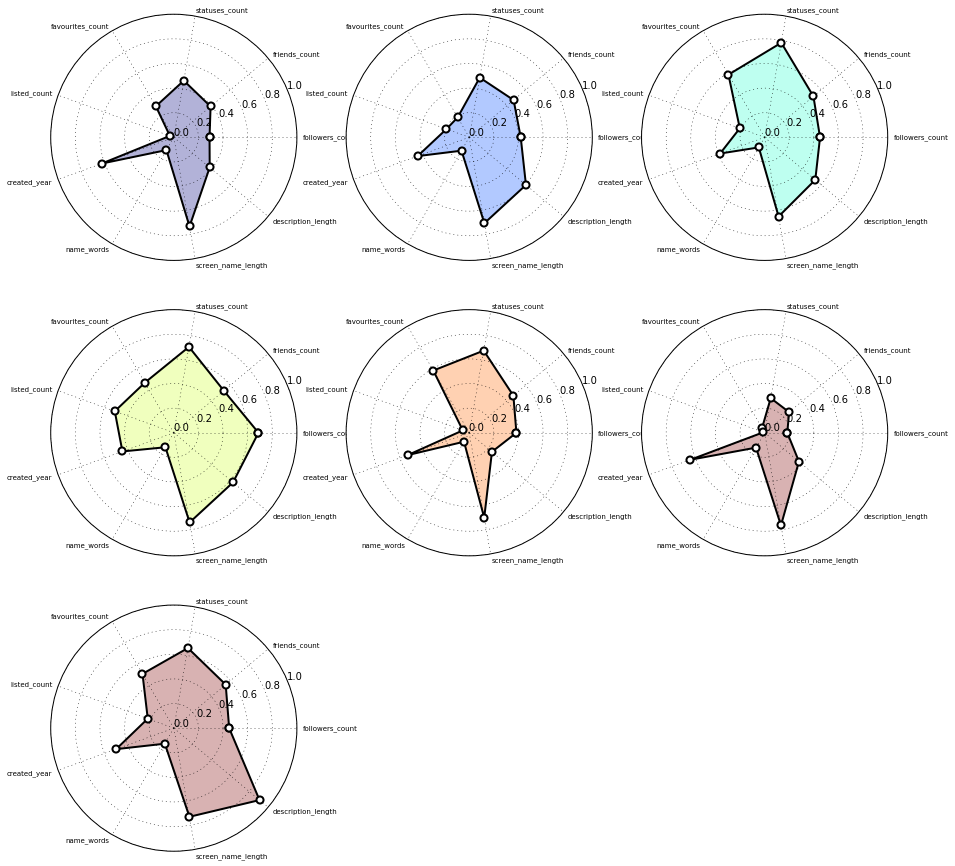

In [132]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.